In [1]:
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt

# 讀取資料表

In [2]:
df = pd.read_csv("GDSC_PDX_Paclitaxel.csv")#,index_col=0)
df = df.rename(columns={'Unnamed: 0':'CELL_LINE_NAME'}) # 把cell_line_name欄位名稱統一（方便做合併）
df_info = pd.read_csv("GDSC_PDX_Paclitaxel_info.csv",index_col=0)
df_test = pd.read_csv("CCLE_PDX_Paclitaxel.csv")#,index_col=0)
df_test = df_test.rename(columns={'CCLE.Cell.Line.Name':'CELL_LINE_NAME'})

# 取欄位交集（兩個資料表都有的欄位）

In [3]:
train_features = set(df.columns)
test_features = set(df_test.columns)
# 把非交集的欄位從資料表中去除（減去差集）
df_train = df.drop(train_features.difference(test_features),axis=1)
df_test = df_test.drop(test_features.difference(train_features),axis=1)

# 用IC50與MAX_CONC_MICROMOLAR欄位計算S或R 並將結果併入訓練資料表中

In [4]:
ans = []
for i in range(len(df_info["IC50"])):
    if list(df_info["IC50"])[i] < list(df_info["MAX_CONC_MICROMOLAR"])[i]:
        ans.append(0) # S
    else:
        ans.append(1) # R
df_info['ans'] = ans
df_bind = df_info[['CELL_LINE_NAME','ans']] ##  合併用的
df_train = pd.merge(df_train,df_bind) ## 訓練用的
print(df_train.shape) # 處理過後有的行列數量

(399, 15175)


# 資料標準化

In [5]:
X = df_train.drop("ans",1) #Feature Matrix 
y = df_train["ans"] #目標變量
df_train = df_train.drop(['CELL_LINE_NAME'], axis=1)

df_ = df_train.drop("ans",axis=1)

normalized_df=(df_ - df_.mean())/df_.std()
normalized_df['ans'] = y # 把標準化前刪掉的ans欄位併回來

# 計算各欄位與欲預測欄位的correlation（pearson方法）

In [6]:
df_train = normalized_df
cor_df = df_train.corr(method ='pearson') # 使用皮爾森方法
cor_df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,OR4N3P,MRPL46,HPR,MIA,LINC00514,OR1D5,MYH4,KRT18P55,TBC1D3P5,ans
TSPAN6,1.000000,0.046208,0.053007,-0.365482,-0.233656,-0.465248,0.149307,0.227825,0.120466,-0.223184,...,-0.215747,-0.130318,-0.157830,0.088224,0.129337,-0.256798,0.067981,0.009864,-0.170854,0.068623
TNMD,0.046208,1.000000,0.040708,0.070092,0.079292,0.044540,-0.108413,-0.103665,-0.030382,0.034691,...,0.058246,0.043290,-0.003097,-0.090955,-0.016635,-0.019272,0.080862,0.063532,0.058706,-0.007491
DPM1,0.053007,0.040708,1.000000,-0.050125,-0.099479,0.032664,0.047902,0.070631,0.015885,-0.120462,...,-0.034802,0.075925,0.016166,0.074368,0.042569,0.058854,0.023932,0.083644,-0.086360,-0.033391
SCYL3,-0.365482,0.070092,-0.050125,1.000000,0.207594,0.364232,-0.095711,-0.160789,0.029839,0.241952,...,0.099734,0.203343,0.098325,-0.039769,0.156156,0.092487,0.061193,0.088698,0.103085,-0.053902
C1orf112,-0.233656,0.079292,-0.099479,0.207594,1.000000,0.039565,-0.144687,-0.298227,-0.034905,0.351181,...,0.045729,0.169987,0.014999,-0.092431,0.003133,0.089290,-0.068675,0.058666,0.145893,-0.119629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OR1D5,-0.256798,-0.019272,0.058854,0.092487,0.089290,0.177333,0.004501,-0.066179,-0.017884,0.077607,...,0.084624,0.124597,0.104716,0.006587,-0.015919,1.000000,-0.046605,0.079913,0.105413,-0.036426
MYH4,0.067981,0.080862,0.023932,0.061193,-0.068675,0.006781,-0.036972,0.095648,0.118941,-0.021334,...,0.019490,0.019301,0.015910,-0.049824,0.004229,-0.046605,1.000000,0.038360,-0.048615,0.041263
KRT18P55,0.009864,0.063532,0.083644,0.088698,0.058666,0.072268,-0.058323,0.018816,0.119819,-0.109738,...,-0.010065,0.107776,0.102372,-0.064870,0.039255,0.079913,0.038360,1.000000,0.166550,0.008065
TBC1D3P5,-0.170854,0.058706,-0.086360,0.103085,0.145893,0.076177,-0.114808,-0.111958,-0.070690,0.042536,...,0.056023,0.088320,0.245291,0.063065,0.033053,0.105413,-0.048615,0.166550,1.000000,0.020543


# 設定一個correlarion閥值來選取要用來訓練的feature(取絕對值後大於閥值)

In [19]:
#Correlation with output variable 
cor_target = abs(cor_df["ans"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.17] #0.17 #設定閥值
print("用來訓練模型的feature數量：",len(relevant_features))

用來訓練模型的feature數量： 108


# 將feature選定後整理為建模用資料

In [20]:
df_train_new = df_train[list(relevant_features.index)]
X = df_train_new.drop("ans",1) #Feature Matrix 
y = df_train_new["ans"] #目標變量

# 調整參數與建模

In [25]:
from sklearn import ensemble, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


# 建立訓練與測試資料
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

score = []
time = []
# 建立 random forest 模型
for i in range(10,290,20):
    time.append(i)
    forest = ensemble.RandomForestClassifier(n_estimators = i)
    forest_fit = forest.fit(train_X, train_y)
    # 預測
    test_y_predicted = forest.predict(test_X)
    # 績效
    scores = cross_val_score(forest,X,y,cv=5,scoring='accuracy')
    print(scores)
    sum = 0
    for j in scores:
        sum += j
    score.append(sum/5)

print("score: ",score)
print("max score: ",max(score))

[0.7125     0.7125     0.725      0.8        0.72151899]
[0.75      0.7625    0.8       0.75      0.7721519]
[0.725      0.775      0.775      0.8125     0.75949367]
[0.7        0.725      0.825      0.7875     0.79746835]
[0.7375     0.7625     0.8125     0.7625     0.81012658]
[0.725      0.75       0.825      0.7625     0.75949367]
[0.725      0.775      0.8        0.8        0.78481013]
[0.7625     0.725      0.8125     0.8        0.79746835]
[0.7375     0.75       0.8        0.775      0.81012658]
[0.7625     0.7625     0.825      0.775      0.79746835]
[0.7375     0.7375     0.8        0.7875     0.79746835]
[0.725      0.7625     0.825      0.7625     0.78481013]
[0.7375     0.75       0.8125     0.8        0.81012658]
[0.7625     0.7625     0.8125     0.8        0.81012658]
score:  [0.7343037974683544, 0.7669303797468354, 0.7693987341772152, 0.7669936708860761, 0.7770253164556962, 0.7643987341772152, 0.7769620253164555, 0.7794936708860758, 0.7745253164556962, 0.7844936708860759

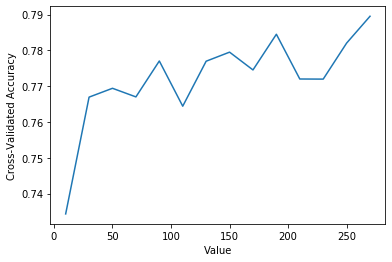

In [26]:
plt.plot(time,score)
plt.xlabel('Value')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [27]:
import xgboost as xgb
# xgb.XGBClassifier(n_estimators = i)

# 建立訓練與測試資料
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

score = []
# 建立 XGBClassifier 模型
for i in range(10,290,20):
    XGB = xgb.XGBClassifier(n_estimators = i)
    forest_fit = XGB.fit(train_X, train_y)
    # 預測
    test_y_predicted = XGB.predict(test_X)
    # 績效
    scores = cross_val_score(XGB,X,y,cv=5,scoring='accuracy')
    print(scores)
    sum = 0
    for j in scores:
        sum += j
    score.append(sum/5)

print("score: ",score)
print("max score: ",max(score))

[0.675      0.775      0.7875     0.725      0.81012658]
[0.6375     0.775      0.8        0.7375     0.75949367]
[0.65       0.775      0.7875     0.75       0.75949367]
[0.6625    0.8       0.8       0.7625    0.7721519]
[0.675     0.7875    0.8       0.75      0.7721519]
[0.675     0.7875    0.825     0.75      0.7721519]
[0.6875     0.7875     0.825      0.7375     0.78481013]
[0.7        0.8        0.8125     0.7375     0.79746835]
[0.725      0.7875     0.8125     0.7375     0.78481013]
[0.725      0.7875     0.8        0.7375     0.78481013]
[0.725      0.7875     0.775      0.7375     0.78481013]
[0.725      0.7875     0.775      0.7375     0.78481013]
[0.7125     0.7875     0.775      0.75       0.79746835]
[0.725      0.7875     0.775      0.75       0.78481013]
score:  [0.7545253164556962, 0.7418987341772152, 0.7443987341772151, 0.7594303797468356, 0.7569303797468355, 0.7619303797468354, 0.7644620253164556, 0.7694936708860759, 0.7694620253164557, 0.7669620253164556, 0.761962

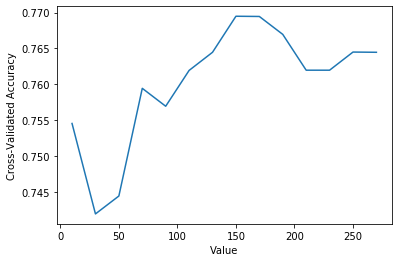

In [28]:
plt.plot(time,score)
plt.xlabel('Value')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [29]:
from sklearn.neighbors import KNeighborsClassifier
# KNeighborsClassifier(n_neighbors = i)

# 建立訓練與測試資料
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

score = []
# 建立 KNeighbors 模型
for i in range(10,290,20):
    KNeighbors = KNeighborsClassifier(n_neighbors = i)
    forest_fit = KNeighbors.fit(train_X, train_y)
    # 預測
    test_y_predicted = KNeighbors.predict(test_X)
    # 績效
    scores = cross_val_score(KNeighbors,X,y,cv=5,scoring='accuracy')
    print(scores)
    sum = 0
    for j in scores:
        sum += j
    score.append(sum/5)

print("score: ",score)
print("max score: ",max(score))

[0.7125     0.725      0.725      0.75       0.75949367]
[0.725      0.725      0.7125     0.7125     0.70886076]
[0.7        0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
[0.7125     0.7125     0.7125     0.7125     0.70886076]
score:  [0.7343987341772152, 0.7167721518987342, 0.7092721518987342, 0.7117721518987341, 0.7117721518987341, 0.7117721518987341, 0.7117721518987341, 0.7117721518987341, 0.7117721518987341, 0.71177215189

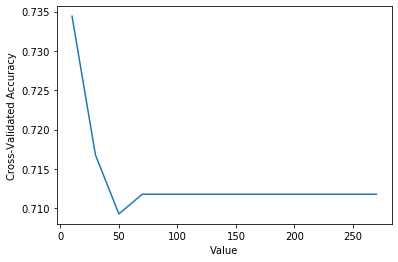

In [30]:
plt.plot(time,score)
plt.xlabel('Value')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# 最好的模型與參數組合

In [51]:
forest = ensemble.RandomForestClassifier(n_estimators = 270) #參數設為最好的
forest_fit = forest.fit(train_X, train_y)
# 預測
test_y_predicted = forest.predict(test_X)
# 績效
scores = cross_val_score(forest,X,y,cv=5,scoring='accuracy')
print(scores)
sum = 0
for i in scores:
    sum+=i
print(sum/5)

[0.725     0.7625    0.8125    0.775     0.7721519]
0.7694303797468354


In [52]:
accuracy = metrics.accuracy_score(test_y, test_y_predicted)
print(accuracy)

0.75


# 測試資料集前處理與預測

In [39]:
df_test = df_test.drop(['CELL_LINE_NAME'], axis=1)

# 過濾掉我們只需要的欄位
test_features = df_test.columns
df_test_ = df_test.drop(test_features.difference(set(relevant_features.index)),axis=1)

# 標準化資料
df_ = df_test_
normalized_df=(df_ - df_.mean())/df_.std()

# 預測
test_y_predicted = forest.predict(normalized_df)

In [40]:
test_y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,

In [41]:
data = {'ans':test_y_predicted}
ans_df = pd.DataFrame(data)
ans_df

,ans
0,0
1,0
2,0
3,0
4,0
...,...
464,0
465,0
466,0
467,0


In [46]:
ans_df = ans_df.replace(0, "S")
ans_df = ans_df.replace(1, "R")
ans_df

,ans
0,S
1,S
2,S
3,S
4,S
...,...
464,S
465,S
466,S
467,S


In [49]:
ans_df.to_csv("ans.csv")